In [1]:

import os

import h5netcdf
from PIL import Image
import scipy.spatial
import scipy.ndimage

import netCDF4 as nc

from veros import VerosSetup, veros_routine, veros_kernel, KernelOutput
from veros.variables import Variable
from veros.core.operators import numpy as npx, update, at
import veros.tools

import matplotlib.pyplot as plt

BASE_PATH = ''
DATA_FILES = veros.tools.get_assets("north_atlantic", os.path.join(BASE_PATH, "assets.json"))
TOPO_MASK_FILE = os.path.join(BASE_PATH, "topo_mask.png")


Importing core modules
 Using computational backend numpy on cpu
 Runtime settings are now locked



In [2]:
topo_mask = npx.flipud(npx.asarray(Image.open(TOPO_MASK_FILE))).T


In [3]:
z_interp

NameError: name 'z_interp' is not defined

In [ ]:
def set_grid(self, state):
    vs = state.variables
    settings = state.settings

    vs.dxt = update(vs.dxt, at[2:-2], (self.x_boundary - settings.x_origin) / settings.nx)
    vs.dyt = update(vs.dyt, at[2:-2], (self.y_boundary - settings.y_origin) / settings.ny)
    vs.dzt = veros.tools.get_vinokur_grid_steps(settings.nz, self.max_depth, 10.0, refine_towards="lower")

In [ ]:
def set_topography(self, state):
    import numpy as onp

    vs = state.variables
    settings = state.settings

    with h5netcdf.File(DATA_FILES["topography"], "r") as topo_file:
        topo_x, topo_y, topo_bottom_depth = (self._get_data(topo_file, k) for k in ("x", "y", "z"))

    topo_mask = npx.flipud(npx.asarray(Image.open(TOPO_MASK_FILE))).T
    topo_bottom_depth = npx.where(topo_mask, 0, topo_bottom_depth)
    topo_bottom_depth = scipy.ndimage.gaussian_filter(
        topo_bottom_depth, sigma=(len(topo_x) / settings.nx, len(topo_y) / settings.ny)
    )
    interp_coords = npx.meshgrid(vs.xt[2:-2], vs.yt[2:-2], indexing="ij")
    interp_coords = npx.rollaxis(npx.asarray(interp_coords), 0, 3)
    z_interp = scipy.interpolate.interpn(
        (onp.array(topo_x), onp.array(topo_y)),
        topo_bottom_depth,
        onp.array(interp_coords),
        method="nearest",
        bounds_error=False,
        fill_value=0,
    )
    vs.kbot = update(
        vs.kbot,
        at[2:-2, 2:-2],
        npx.where(
            z_interp < 0.0,
            1 + npx.argmin(npx.abs(z_interp[:, :, npx.newaxis] - vs.zt[npx.newaxis, npx.newaxis, :]), axis=2),
            0,
        ),
    )
    vs.kbot = npx.where(vs.kbot < settings.nz, vs.kbot, 0)


In [4]:
ROMS_bry = "/scratch/zl28/FASTSCRATCH/AS24th_5s_n2pzd2_grub_dalma/3day/roms_bry.nc" # boundaries
ROMS_frc = "/scratch/zl28/FASTSCRATCH/AS24th_5s_n2pzd2_grub_dalma/3day/roms_frc.nc" # forcings 
ROMS_ic = "/scratch/zl28/FASTSCRATCH/AS24th_5s_n2pzd2_grub_dalma/3day/roms_ini.nc" # initial cond
ROMS_topo = "/scratch/zl28/FASTSCRATCH/AS24th_5s_n2pzd2_grub_dalma/3day/AS24th_5s_marginseas_grdZ.nc" # grid and topo

In [21]:
vm_bry = nc.Dataset(ROMS_bry)

In [ ]:
vm_frc = nc.Dataset(ROMS_frc)

In [ ]:
vm_ic = nc.Dataset(ROMS_ic)

In [6]:
vm_topo = nc.Dataset(ROMS_topo)

In [12]:
vm_topo['f'][:] 

masked_array(
  data=[[-1.34347574e-05, -1.34347574e-05, -1.34347574e-05, ...,
         -1.34347574e-05, -1.34347574e-05, -1.34347574e-05],
        [-1.33298864e-05, -1.33298864e-05, -1.33298864e-05, ...,
         -1.33298864e-05, -1.33298864e-05, -1.33298864e-05],
        [-1.32250014e-05, -1.32250014e-05, -1.32250014e-05, ...,
         -1.32250014e-05, -1.32250014e-05, -1.32250014e-05],
        ...,
        [ 7.36965576e-05,  7.36965576e-05,  7.36965576e-05, ...,
          7.36965576e-05,  7.36965576e-05,  7.36965576e-05],
        [ 7.37751571e-05,  7.37751571e-05,  7.37751571e-05, ...,
          7.37751571e-05,  7.37751571e-05,  7.37751571e-05],
        [ 7.38536987e-05,  7.38536987e-05,  7.38536987e-05, ...,
          7.38536987e-05,  7.38536987e-05,  7.38536987e-05]],
  mask=False,
  fill_value=1e+20)

In [7]:
vm_topo.variables 

{'xl': <class 'netCDF4._netCDF4.Variable'>
 float64 xl(one)
     long_name: domain length in the XI-direction
     units: meter
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'el': <class 'netCDF4._netCDF4.Variable'>
 float64 el(one)
     long_name: domain length in the ETA-direction
     units: meter
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depthmin': <class 'netCDF4._netCDF4.Variable'>
 float64 depthmin(one)
     long_name: Shallow bathymetry clipping depth
     units: meter
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depthmax': <class 'netCDF4._netCDF4.Variable'>
 float64 depthmax(one)
     long_name: Deep bathymetry clipping depth
     units: meter
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'spherical': <class 'netCDF4.

In [39]:
vm_topo.variables['hraw']

<class 'netCDF4._netCDF4.Variable'>
float64 hraw(bath, eta_rho, xi_rho)
    long_name: Working bathymetry at RHO-points
    units: meter
unlimited dimensions: bath
current shape = (0, 898, 1082)
filling on, default _FillValue of 9.969209968386869e+36 used

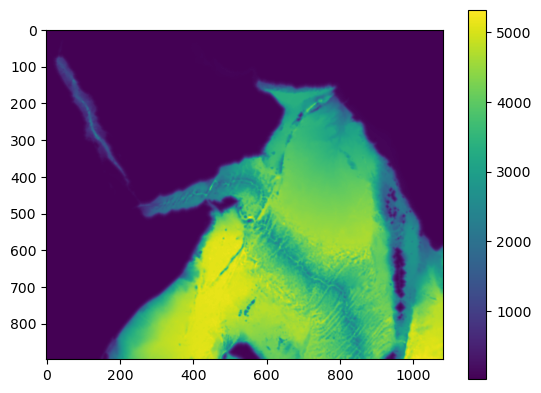

In [40]:
plt.imshow(vm_topo.variables['h'][:][::-1])
plt.colorbar()

In [30]:
vm_topo.variables['h']

<class 'netCDF4._netCDF4.Variable'>
float64 h(eta_rho, xi_rho)
    long_name: Final bathymetry at RHO-points
    units: meter
unlimited dimensions: 
current shape = (898, 1082)
filling on, default _FillValue of 9.969209968386869e+36 used

In [11]:
nx, ny, nz = 250, 350, 50

In [2]:
def _get_data(f, var):
    """Retrieve variable from h5netcdf file"""
    var_obj = f.variables[var]
    return npx.array(var_obj).T



In [7]:
vm_topo = nc.Dataset(DATA_FILES["topography"])

In [9]:
vm_topo.variables

{'x': <class 'netCDF4._netCDF4.Variable'>
 float64 x(x)
     standard_name: longitude
     long_name: longitude
     units: degrees_east
     axis: X
 unlimited dimensions: 
 current shape = (6913,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'y': <class 'netCDF4._netCDF4.Variable'>
 float64 y(y)
     standard_name: latitude
     long_name: latitude
     units: degrees_north
     axis: Y
 unlimited dimensions: 
 current shape = (5556,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'z': <class 'netCDF4._netCDF4.Variable'>
 int32 z(y, x)
     long_name: z
     _FillValue: -2147483648
     missing_value: -2147483648
     actual_range: [-10898.   8271.]
 unlimited dimensions: 
 current shape = (5556, 6913)
 filling on}

In [3]:
topo_mask = npx.flipud(npx.asarray(Image.open(TOPO_MASK_FILE))).T
with h5netcdf.File(DATA_FILES["topography"], "r") as topo_file:
    topo_x, topo_y, topo_bottom_depth = (_get_data(topo_file, k) for k in ("x", "y", "z"))


In [5]:
DATA_FILES["topography"]

'/home/so2495/.veros/assets/north_atlantic/ETOPO1_Bed_g_gmt4_NA.nc'

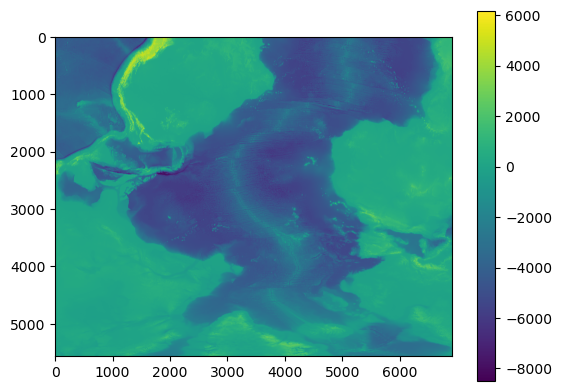

In [12]:
plt.imshow(topo_bottom_depth.T)
plt.colorbar()

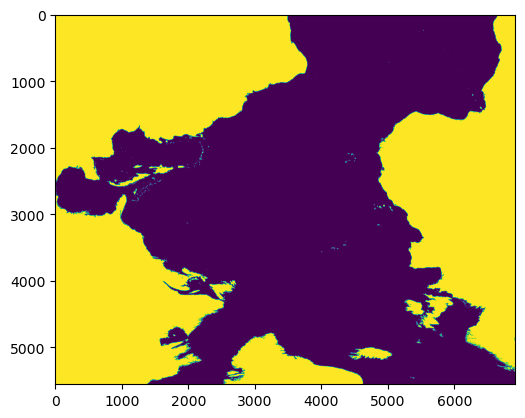

In [6]:
plt.imshow(topo_mask.T)


In [15]:
topo_mask = npx.flipud(npx.asarray(Image.open(TOPO_MASK_FILE))).T
topo_bottom_depth = npx.where(topo_mask, 0, topo_bottom_depth)


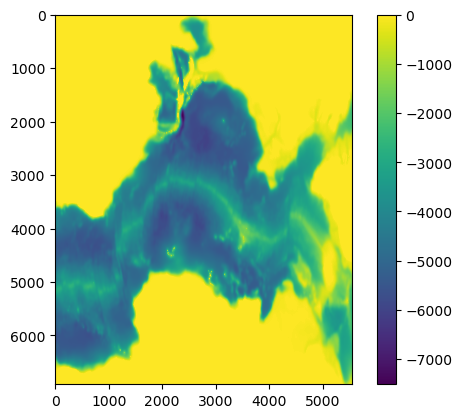

In [16]:
plt.imshow(topo_bottom_depth)
plt.colorbar()

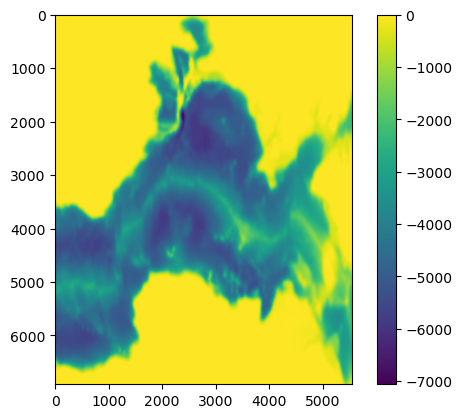

In [17]:
topo_bottom_depth = scipy.ndimage.gaussian_filter(
    topo_bottom_depth, sigma=(len(topo_x) / nx, len(topo_y) / ny)
)
plt.imshow(topo_bottom_depth)
plt.colorbar()